In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib as plt

In [2]:
pd.set_option('display.max_columns', None)  # show all columns
DATA_PATH = "data/bitcoin_data.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,btc_difficulty,btc_miners_revenue,btc_transaction_fees,btc_cost_per_transaction_percent,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd
0,2010-02-23 00:00:00,0.0,2110700.0,0.0,0.0,0.0,0.000216,0.0,1.0,0.0,0.000032,2.527738,0.0,0.0,25100.000000,0.0,252.0,252.0,42613.0,252.0,252.0,12600.0,50.0,0.0
1,2010-02-24 00:00:00,0.0,2120200.0,0.0,0.0,0.0,0.000282,0.0,1.0,0.0,0.000036,3.781179,0.0,0.0,179.245283,0.0,195.0,196.0,42809.0,196.0,196.0,14800.0,5300.0,0.0
2,2010-02-25 00:00:00,0.0,2127600.0,0.0,0.0,0.0,0.000227,0.0,1.0,0.0,0.000028,3.781179,0.0,0.0,1057.142857,0.0,150.0,150.0,42959.0,150.0,150.0,8100.0,700.0,0.0
3,2010-02-26 00:00:00,0.0,2136100.0,0.0,0.0,0.0,0.000319,0.0,1.0,0.0,0.000032,3.781179,0.0,0.0,64.582059,0.0,176.0,176.0,43135.0,176.0,176.0,29349.0,13162.0,0.0
4,2010-02-27 00:00:00,0.0,2144750.0,0.0,0.0,0.0,0.000223,0.0,1.0,0.0,0.000033,3.781179,0.0,0.0,1922.222222,0.0,176.0,176.0,43311.0,176.0,176.0,9101.0,450.0,0.0


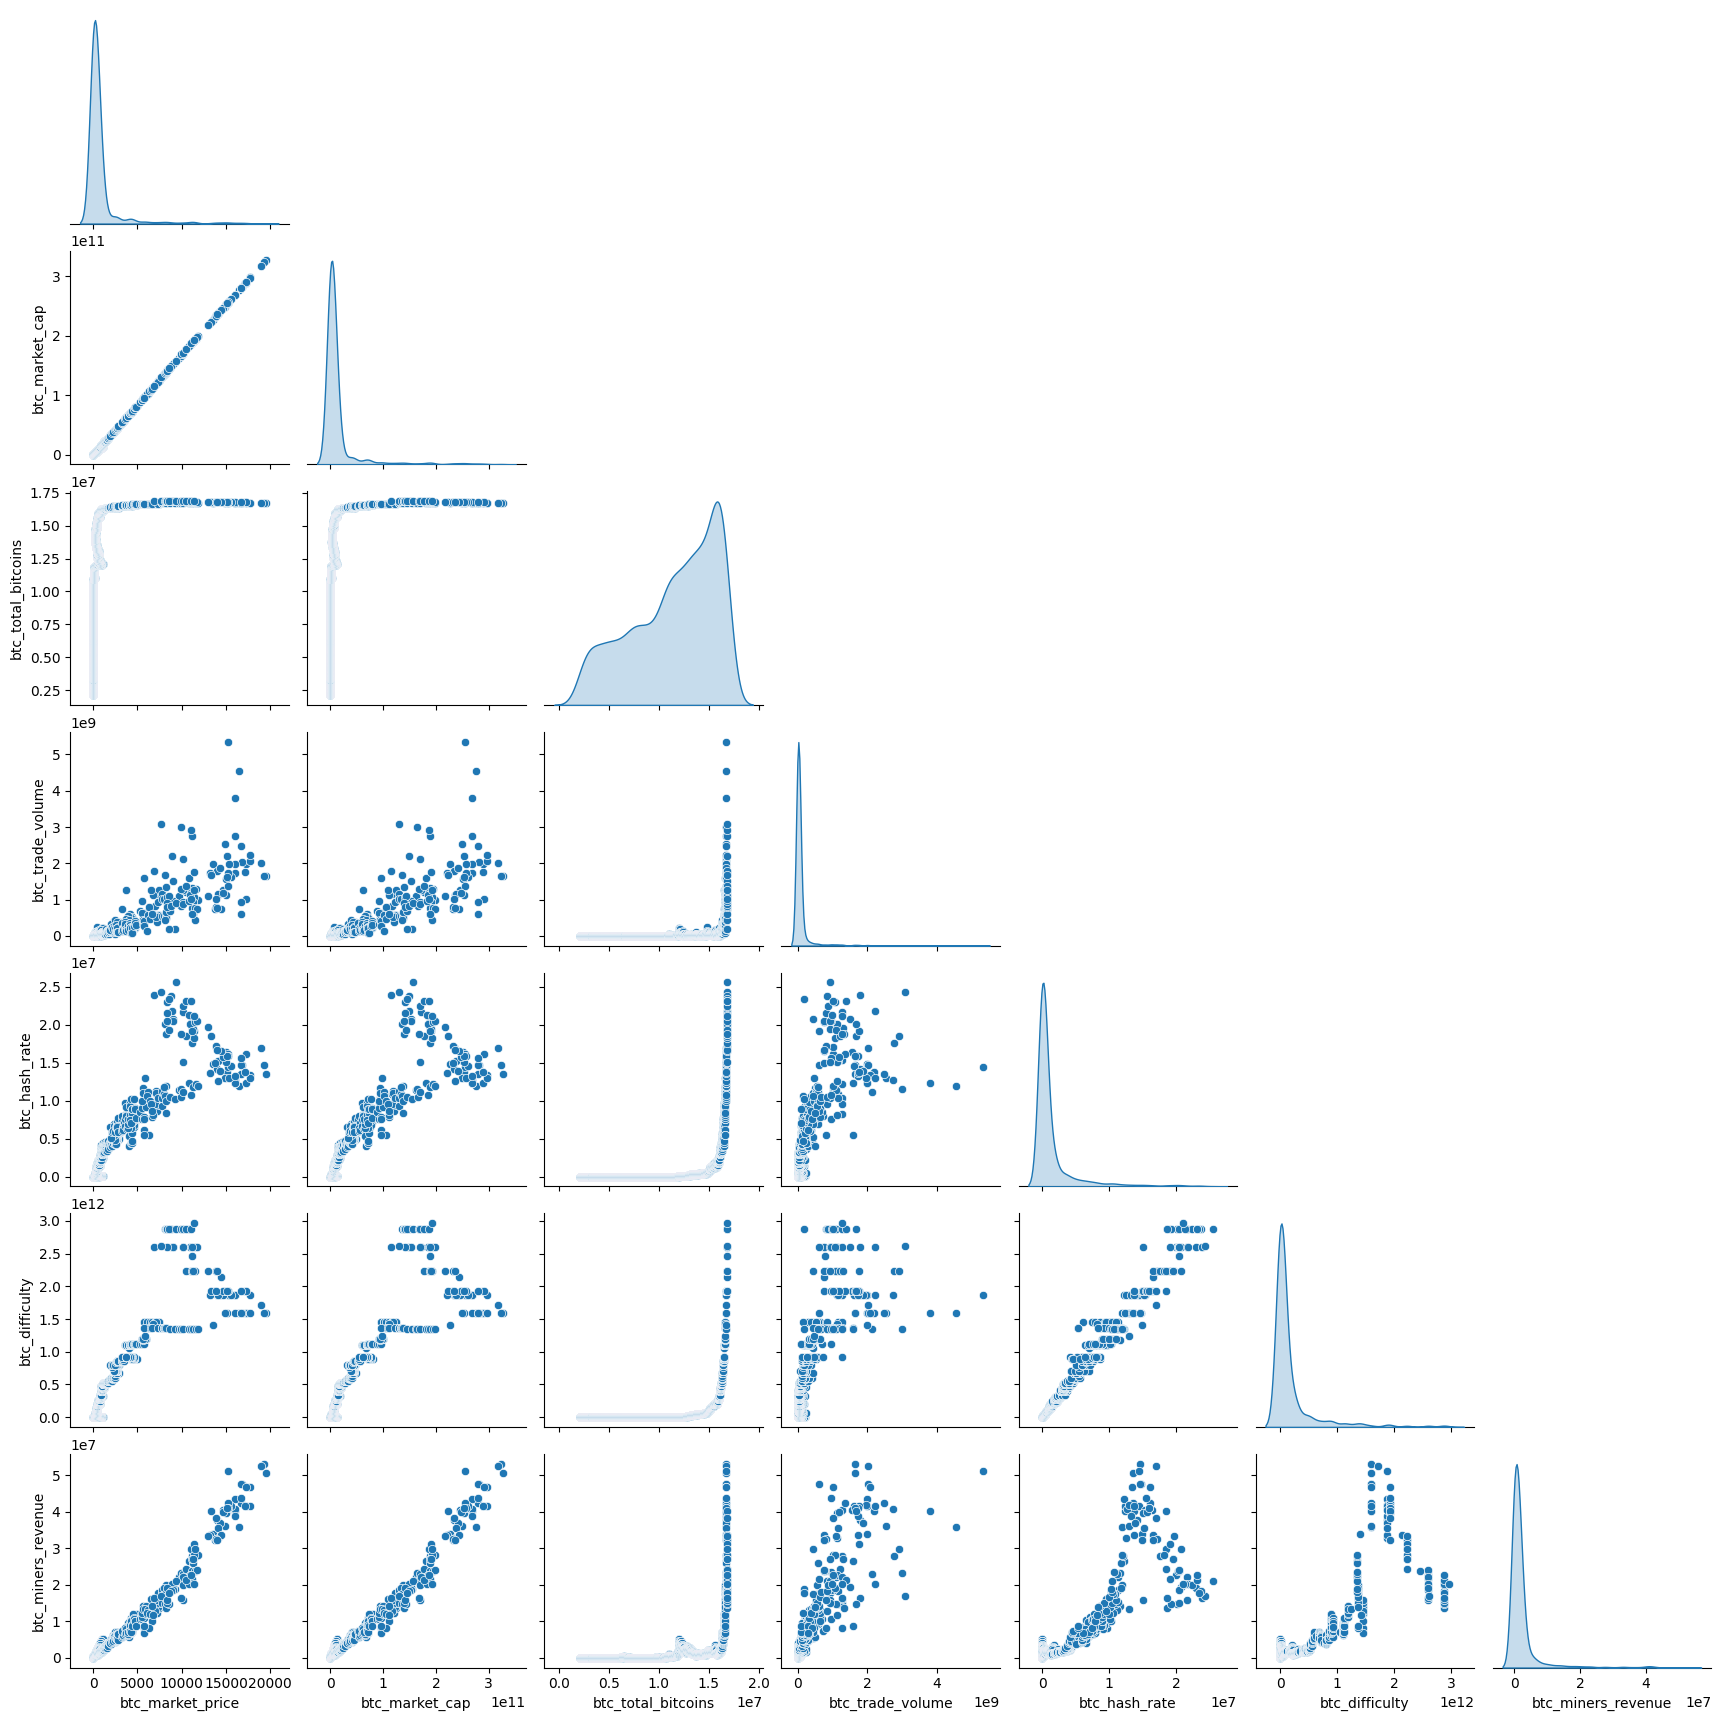

In [3]:
sns.pairplot(df[['btc_market_price', 'btc_market_cap', 'btc_total_bitcoins',
                 'btc_trade_volume', 
                 'btc_hash_rate', 
                 'btc_difficulty', 'btc_miners_revenue']], diag_kind="kde", corner=True)

Let's do some very basic initial processing so we can immediately do so naive linear regression modelling. We need to drop the date column from the beginning so we only have numeric predictors.


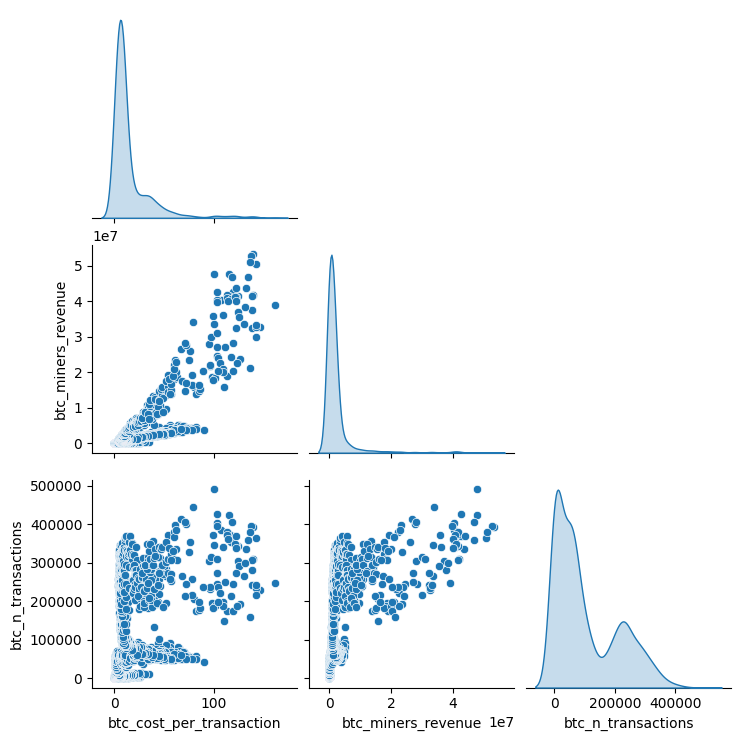

In [4]:
sns.pairplot(df[['btc_cost_per_transaction', 'btc_miners_revenue', 'btc_n_transactions']], diag_kind="kde", corner=True)

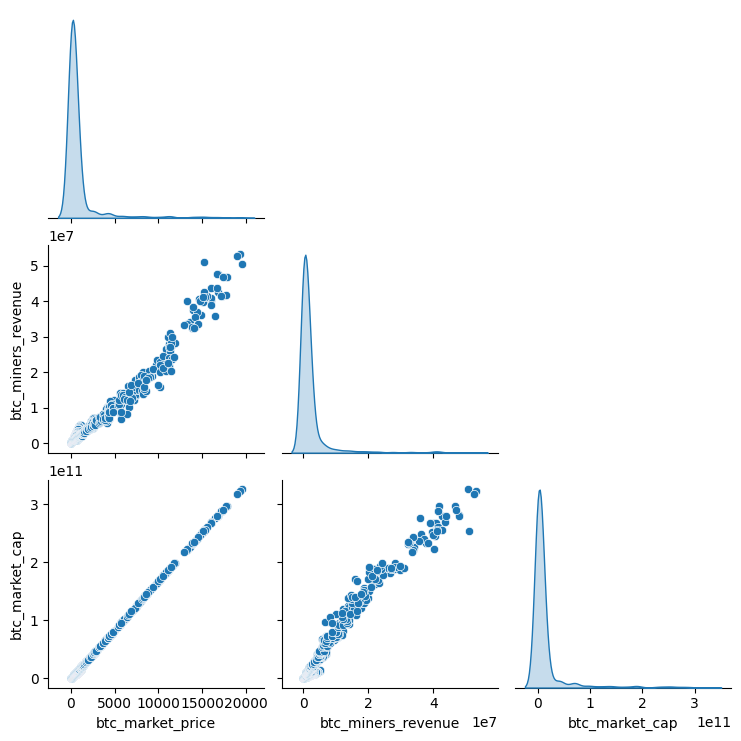

In [5]:
sns.pairplot(df[['btc_market_price', 'btc_miners_revenue', 'btc_market_cap']], diag_kind="kde", corner=True)

In [6]:
# Drop Date column because it is a string, so it won't work with LinearRegression
cols_to_drop = ["Date", "btc_market_cap", "btc_total_bitcoins"]
df = df.drop(cols_to_drop, axis=1)
df.corr()['btc_market_price'].sort_values(ascending=False)

btc_market_price                                       1.000000
btc_miners_revenue                                     0.985403
btc_estimated_transaction_volume_usd                   0.960016
btc_hash_rate                                          0.904188
btc_difficulty                                         0.900673
btc_trade_volume                                       0.866398
btc_cost_per_transaction                               0.830943
btc_transaction_fees                                   0.778896
btc_n_transactions_total                               0.698533
btc_blocks_size                                        0.693650
btc_n_unique_addresses                                 0.661198
btc_n_transactions_excluding_chains_longer_than_100    0.565522
btc_n_transactions                                     0.564541
btc_avg_block_size                                     0.558922
btc_n_transactions_excluding_popular                   0.554186
btc_n_transactions_per_block            

In [7]:
# Count NaNs by rows
missing = df.isna().sum(axis=1)
print(missing.value_counts())

0    2899
1      21
Name: count, dtype: int64


There are only 21 rows that contains missing values. This is less than 1% of the total number of observations, so dropping this rows isn't really harmful. 

In [8]:
df = df.dropna()

Let's see the correlation between different predictors in our dataset

We want to predict btc_market_price in 4 days ahead and we use the data from the previous 3 days to do so. Therefore, we can consider the data from the current row and create "lag" variables that contain the data from the features from the previous 2 days. We also create a new response column btc_market_price_future that holds that market_price in 4 days time.

In [9]:
# Assume df['btc_market_price'] exists
N, p = df.shape
df_reshaped = df.copy()
y = df_reshaped['btc_market_price']
# Let's say df has btc_market_price and some predictors
# # Create lagged features
original_cols = df.columns.tolist()
for col in original_cols:
    df_reshaped[f'{col}_lag1'] = df[col].shift(1)
    df_reshaped[f'{col}_lag2'] = df[col].shift(2)

df_reshaped['btc_market_price_future'] = y.shift(-4)
assert(len(df_reshaped.columns) == 3 * p + 1)
df_reshaped = df_reshaped.dropna()

In [10]:
print(len(df_reshaped.columns))
print(len(df.columns))
print(df_reshaped.columns)

64
21
Index(['btc_market_price', 'btc_trade_volume', 'btc_blocks_size',
       'btc_avg_block_size', 'btc_n_orphaned_blocks',
       'btc_n_transactions_per_block', 'btc_median_confirmation_time',
       'btc_hash_rate', 'btc_difficulty', 'btc_miners_revenue',
       'btc_transaction_fees', 'btc_cost_per_transaction_percent',
       'btc_cost_per_transaction', 'btc_n_unique_addresses',
       'btc_n_transactions', 'btc_n_transactions_total',
       'btc_n_transactions_excluding_popular',
       'btc_n_transactions_excluding_chains_longer_than_100',
       'btc_output_volume', 'btc_estimated_transaction_volume',
       'btc_estimated_transaction_volume_usd', 'btc_market_price_lag1',
       'btc_market_price_lag2', 'btc_trade_volume_lag1',
       'btc_trade_volume_lag2', 'btc_blocks_size_lag1', 'btc_blocks_size_lag2',
       'btc_avg_block_size_lag1', 'btc_avg_block_size_lag2',
       'btc_n_orphaned_blocks_lag1', 'btc_n_orphaned_blocks_lag2',
       'btc_n_transactions_per_block_lag1',


In [12]:
pd.set_option('display.max_rows', None)   # no truncation
df_reshaped.corr()['btc_market_price_future'].sort_values(ascending=False)

btc_market_price_future                                     1.000000
btc_market_price                                            0.989783
btc_market_price_lag1                                       0.987504
btc_market_price_lag2                                       0.983965
btc_miners_revenue                                          0.972481
btc_miners_revenue_lag1                                     0.968279
btc_miners_revenue_lag2                                     0.963378
btc_estimated_transaction_volume_usd_lag1                   0.957762
btc_estimated_transaction_volume_usd_lag2                   0.957201
btc_estimated_transaction_volume_usd                        0.957037
btc_hash_rate                                               0.901348
btc_hash_rate_lag1                                          0.900352
btc_hash_rate_lag2                                          0.898986
btc_difficulty                                              0.897769
btc_difficulty_lag1               

Now we split the data using first 70% for training and the last 30% as a test set. Note that we do not randomly split because the data is longitudinal.

In [13]:
# Split into train/test dataframes
train_size = int(len(df_reshaped) * 0.7)
train_df = df_reshaped.iloc[:train_size]
test_df  = df_reshaped.iloc[train_size:]

# Split by predictors/response so we can pass to sklearn
response_col_name = 'btc_market_price_future'
X_train = train_df.drop(response_col_name, axis=1)
y_train = train_df[response_col_name]
X_test = test_df.drop(response_col_name, axis=1)
y_test = test_df[response_col_name]
X_train.head()

,btc_market_price,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,btc_difficulty,btc_miners_revenue,btc_transaction_fees,btc_cost_per_transaction_percent,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,btc_market_price_lag1,btc_market_price_lag2,btc_trade_volume_lag1,btc_trade_volume_lag2,btc_blocks_size_lag1,btc_blocks_size_lag2,btc_avg_block_size_lag1,btc_avg_block_size_lag2,btc_n_orphaned_blocks_lag1,btc_n_orphaned_blocks_lag2,btc_n_transactions_per_block_lag1,btc_n_transactions_per_block_lag2,btc_median_confirmation_time_lag1,btc_median_confirmation_time_lag2,btc_hash_rate_lag1,btc_hash_rate_lag2,btc_difficulty_lag1,btc_difficulty_lag2,btc_miners_revenue_lag1,btc_miners_revenue_lag2,btc_transaction_fees_lag1,btc_transaction_fees_lag2,btc_cost_per_transaction_percent_lag1,btc_cost_per_transaction_percent_lag2,btc_cost_per_transaction_lag1,btc_cost_per_transaction_lag2,btc_n_unique_addresses_lag1,btc_n_unique_addresses_lag2,btc_n_transactions_lag1,btc_n_transactions_lag2,btc_n_transactions_total_lag1,btc_n_transactions_total_lag2,btc_n_transactions_excluding_popular_lag1,btc_n_transactions_excluding_popular_lag2,btc_n_transactions_excluding_chains_longer_than_100_lag1,btc_n_transactions_excluding_chains_longer_than_100_lag2,btc_output_volume_lag1,btc_output_volume_lag2,btc_estimated_transaction_volume_lag1,btc_estimated_transaction_volume_lag2,btc_estimated_transaction_volume_usd_lag1,btc_estimated_transaction_volume_usd_lag2
2,0.0,0.0,0.0,0.000227,0.0,1.0,0.0,0.000028,3.781179,0.0,0.0,1057.142857,0.0,150.0,150.0,42959.0,150.0,150.0,8100.0,700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000282,0.000216,0.0,0.0,1.0,1.0,0.0,0.0,0.000036,0.000032,3.781179,2.527738,0.0,0.0,0.0,0.0,179.245283,25100.000000,0.0,0.0,195.0,252.0,196.0,252.0,42809.0,42613.0,196.0,252.0,196.0,252.0,14800.0,12600.0,5300.0,50.0,0.0,0.0
3,0.0,0.0,0.0,0.000319,0.0,1.0,0.0,0.000032,3.781179,0.0,0.0,64.582059,0.0,176.0,176.0,43135.0,176.0,176.0,29349.0,13162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000227,0.000282,0.0,0.0,1.0,1.0,0.0,0.0,0.000028,0.000036,3.781179,3.781179,0.0,0.0,0.0,0.0,1057.142857,179.245283,0.0,0.0,150.0,195.0,150.0,196.0,42959.0,42809.0,150.0,196.0,150.0,196.0,8100.0,14800.0,700.0,5300.0,0.0,0.0
4,0.0,0.0,0.0,0.000223,0.0,1.0,0.0,0.000033,3.781179,0.0,0.0,1922.222222,0.0,176.0,176.0,43311.0,176.0,176.0,9101.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000319,0.000227,0.0,0.0,1.0,1.0,0.0,0.0,0.000032,0.000028,3.781179,3.781179,0.0,0.0,0.0,0.0,64.582059,1057.142857,0.0,0.0,176.0,150.0,176.0,150.0,43135.0,42959.0,176.0,150.0,176.0,150.0,29349.0,8100.0,13162.0,700.0,0.0,0.0
5,0.0,0.0,0.0,0.000291,0.0,1.0,0.0,0.000030,3.781179,0.0,0.0,154.285714,0.0,165.0,165.0,43476.0,165.0,165.0,13399.0,5250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000223,0.000319,0.0,0.0,1.0,1.0,0.0,0.0,0.000033,0.000032,3.781179,3.781179,0.0,0.0,0.0,0.0,1922.222222,64.582059,0.0,0.0,176.0,176.0,176.0,176.0,43311.0,43135.0,176.0,176.0,176.0,176.0,9101.0,29349.0,450.0,13162.0,0.0,0.0
6,0.0,0.0,0.0,0.000228,0.0,1.0,0.0,0.000035,3.781179,0.0,0.0,930.000000,0.0,187.0,187.0,43663.0,187.0,187.0,10300.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000291,0.000223,0.0,0.0,1.0,1.0,0.0,0.0,0.000030,0.000033,3.781179,3.781179,0.0,0.0,0.0,0.0,154.285714,1922.222222,0.0,0.0,165.0,176.0,165.0,176.0,43476.0,43311.0,165.0,176.0,165.0,176.0,13399.0,9101.0,5250.0,450.0,0.0,0.0


In [25]:
pd.set_option('display.max_rows', None)   # no truncation
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]
vif_data.head(68)

,feature,VIF
0,btc_market_price,6.470641e+02
1,btc_trade_volume,5.257862e+00
2,btc_blocks_size,1.865540e+08
3,btc_avg_block_size,6.995018e+02
4,btc_n_orphaned_blocks,2.106092e+00
5,btc_n_transactions_per_block,5.103912e+01
6,btc_median_confirmation_time,3.232616e+01
7,btc_hash_rate,5.018319e+02
8,btc_difficulty,5.802041e+03
9,btc_miners_revenue,4.055684e+02


Now we'll naively apply linear regression just to see what accuracy we get

In [20]:
lr = LinearRegression().fit(X_train, y_train) # fit to training data
pred = lr.predict(X_test)

lr_Rsquared_score = lr.score(X_train, y_train)
print("Naive R^2 score: ", lr_Rsquared_score)

yhat = lr.predict(X_test)
loss = mean_squared_error(y_test, yhat)
print("RMSE: ", np.sqrt(loss))

Naive R^2 score:  0.9849867304577415
RMSE:  761.3273475209677


R^2 is practically 1 on the training and our Root Mean Squared Error is only ~$800 which is already quite good. Likely this is because we have included the predictors such as previous market_price and market_caps which are very highly correlated with the future market price a few days later.

Let's use lagged versions of the variables

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
alphas = [0.1, 1.0, 10.0, 100.0]
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)
print("Best alpha:", ridge_cv.alpha_)
y_pred = ridge_cv.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = ridge_cv.score(X_test_scaled, y_test)
print("R^2:", r2)
print("RMSE:", rmse)

Best alpha: 10.0
R^2: 0.8842425690896198
RMSE: 1316.2773119568897


In [22]:
coef_df = pd.DataFrame([ridge_cv.coef_], columns=X_train.columns)
coef_df

,btc_market_price,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,btc_difficulty,btc_miners_revenue,btc_transaction_fees,btc_cost_per_transaction_percent,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,btc_market_price_lag1,btc_market_price_lag2,btc_trade_volume_lag1,btc_trade_volume_lag2,btc_blocks_size_lag1,btc_blocks_size_lag2,btc_avg_block_size_lag1,btc_avg_block_size_lag2,btc_n_orphaned_blocks_lag1,btc_n_orphaned_blocks_lag2,btc_n_transactions_per_block_lag1,btc_n_transactions_per_block_lag2,btc_median_confirmation_time_lag1,btc_median_confirmation_time_lag2,btc_hash_rate_lag1,btc_hash_rate_lag2,btc_difficulty_lag1,btc_difficulty_lag2,btc_miners_revenue_lag1,btc_miners_revenue_lag2,btc_transaction_fees_lag1,btc_transaction_fees_lag2,btc_cost_per_transaction_percent_lag1,btc_cost_per_transaction_percent_lag2,btc_cost_per_transaction_lag1,btc_cost_per_transaction_lag2,btc_n_unique_addresses_lag1,btc_n_unique_addresses_lag2,btc_n_transactions_lag1,btc_n_transactions_lag2,btc_n_transactions_total_lag1,btc_n_transactions_total_lag2,btc_n_transactions_excluding_popular_lag1,btc_n_transactions_excluding_popular_lag2,btc_n_transactions_excluding_chains_longer_than_100_lag1,btc_n_transactions_excluding_chains_longer_than_100_lag2,btc_output_volume_lag1,btc_output_volume_lag2,btc_estimated_transaction_volume_lag1,btc_estimated_transaction_volume_lag2,btc_estimated_transaction_volume_usd_lag1,btc_estimated_transaction_volume_usd_lag2
0,114.694524,1.936701,-2.703211,2.139989,0.269105,6.180033,1.546161,-0.144908,-7.465279,3.651981,-1.526657,0.139532,8.847433,-2.382266,-7.442834,12.491678,-1.860194,2.504965,0.472756,-0.833208,4.452339,57.018211,23.576219,2.96213,1.62482,-2.698179,-2.718304,2.047279,-1.359818,0.464479,0.144527,7.568068,4.547479,-0.459553,-1.581952,1.578099,4.388728,-10.392732,-12.276364,-6.356118,-8.794564,-0.724232,-1.018368,0.132661,0.163115,7.07223,0.875432,-0.350583,1.876114,-4.870302,-6.354221,12.489539,12.495028,0.120369,1.851434,-0.423176,-2.281809,-0.006712,-0.32765,-0.132589,0.117738,5.374545,4.38605


In [23]:
avg_change_in_price = np.sqrt(mean_squared_error(df_reshaped['btc_market_price_future'], df_reshaped['btc_market_price']))
print("RMSE between the btc_market_price and btc_market_price_future: ", avg_change_in_price)

RMSE between the btc_market_price and btc_market_price_future:  343.98010158489393


Just using the previous price as a way to guess the future price leads to a very root mean squared error. So as long as we use previous prices we will likely get a very good regression result.

,feature,VIF
0,btc_market_price,6.470641e+02
1,btc_trade_volume,5.257862e+00
2,btc_blocks_size,1.865540e+08
3,btc_avg_block_size,6.995018e+02
4,btc_n_orphaned_blocks,2.106092e+00
5,btc_n_transactions_per_block,5.103912e+01
6,btc_median_confirmation_time,3.232616e+01
7,btc_hash_rate,5.018319e+02
8,btc_difficulty,5.802041e+03
9,btc_miners_revenue,4.055684e+02
